# SPRINT 8 - Visualización de datos con Python

In [14]:
# Importa todas las bibliotecas a usar y crea las funciones auxiliares
# que se usarán en este bloc de notas.
import configparser
import mysql.connector
import pandas as pd
import math

LF="\n"

# Aquí configurando cosas de genéricas de Pandas
pd.set_option("display.max.columns", None)
pd.options.mode.copy_on_write = True

def is_defined(varname):
    return varname in globals()

def is_dataFrame(varname):
    return is_defined(varname) \
        and type(globals().get(varname)) is pd.core.frame.DataFrame

def db_connect():
    '''
    Connects to the MySQL / MariaDB database defined in the
    `db.ini` configuration file.
    It declares `db` connection pointer as global, and it also
    returns it, allowing the function to be encapsulated as
    a module function.
    '''
    try:
        cfgFp = open('db.ini', mode='r')
        iniFp = configparser.ConfigParser()
        iniFp.read_file(cfgFp)
        dbCfg = dict(iniFp.items('database'))

        # print(dbCfg, dbCfg['host'])

        global db
        if not is_defined('db') or not db.is_connected():
            db = mysql.connector.connect(
                host=dbCfg['host'],
                database=dbCfg['database'],
                user=dbCfg['user'],
                password=dbCfg['password']
            )
            print("Conectado!")

        return db

    except Exception as e:
        exit("Error:", e)

# Funciones para crear listas de colores para columnas
def list_dividers(numbers, n):
    max_value = max(numbers)
    print(max_value)
    next_multiple_of_5 = math.ceil(max_value / 5) * 5

    points = []

    for i in range(1, n):
        point = int((i / n) * next_multiple_of_5)
        points.append(point)

    return points

def color_list_to_dict(values, color_list):
    keys      = list_dividers(values, len(color_list))
    color_map = dict(zip(keys+['else'], color_list))
    return color_map

def get_color(number, color_map):
    sorted_keys = sorted(key for key in color_map.keys() if isinstance(key, int))

    # Primero los valores extremos...
    if number < sorted_keys[0]:
        return color_map[sorted_keys[0]]
    elif number > sorted_keys[-1]:
        return color_map['else']

    # Ahora los valores de las keys
    for key in sorted_keys:
        if number < key:
            return color_map[key]

    return color_map[sorted_keys[-1]]

def column_colors(values, color_map: dict):
    '''
    Calculates a color list for a given list of values, setting the color
    for that value from a dictionary.

    The 'else' key sets the color for any value greater than the last defined.
    The dict will be sorted numerically, so is it not necessary (but better for
    legibility) to create it already sorted.

    Usage:
        values = [2,4,5,7,9]
        colormap1 = {4: 'red', 8: 'amber', 'else': 'green'}
        colormap2 = {3: 'orange', 5: 'amber', 8: 'cyan', 'else': 'green'}

        values2   = [10, 6, 10, 198, 12, 11, 116, 10, 4]
        colormap3 = ['red', 'amber', 'green']

        column_color(values, colormap1)

        Would return

        ['red', 'amber', 'amber', 'amber', 'green']

        While

        column_color(values, colormap2)

        Should return

        ['orange', 'amber', 'amber', 'cyan', 'green']
    '''

    # color_map _can_ be a list of colors, so it can be converted into a dict
    # by calculating the keys with `list_dividers()`
    if type(color_map) is list:
        color_map = dict(zip(
            list_dividers(values, len(color_map))+['else'],
            color_map
        ))
        # print(color_map)

    cc = []

    for n in values:
        cc.append(get_color(n, color_map))
    return cc


## Tarea S08.01

### Nivel 1
Realitza la connexió en Python amb el MySQL Workbench per a carregar tota la informació que tens en les taules.

<div class="alert alert-block alert-warning">

**NOTA:**  
Esta descripción es un tanto confusa: Python **NO** se conecta con *MySQL Workbench*; se puede conectar con el **servidor** de base de datos (RDBMS: _Relational DataBase Management Server_) MySQL (o MariaDB, o PostgreSQL, o...). *MySQL Workbench* es un **cliente** (que sí, puede gestionar el servidor) que se conecta al RDBMS, igual que lo hará Python.  
Puede que parezca "más fácil de entender", pero sigue siendo incorrecto.

Si en una entrevista técnica el aspirante dijese eso, posiblemente perdería puntos.
</div>

Realitzaràs una visualització per a cada exercici. Comenta el que et crida l'atenció de graficar aquesta variable, justifica l'elecció del gràfic i interpreta els resultats en funció de les teves dades.

####

#### Conectar a DB y tablas
Conectando a la DB y cargando las tablas que se usarán en los ejercicios.

In [15]:
if not is_defined('db'):
    db_connect()

# extraer los datos de la DB. Iré añadiendo tablas según las vaya usando...
def load_tables():
    global tr_df, user_df, co_df, pr_df, prtr_df
    try:
        if not is_dataFrame('tr_df'):
            tr_df   = pd.read_sql("SELECT * FROM `transaction`", db)
            print("Tabla 'transaction' cargada correctamente")

        if not is_dataFrame('user_df'):
            user_df = pd.read_sql("SELECT * FROM `user`", db)
            print("Tabla 'user' cargada correctamente")

        if not is_dataFrame('co_df'):
            co_df = pd.read_sql("SELECT * FROM company", db)
            print("Tabla 'company' cargada correctamente")

        if not is_dataFrame('prtr_df'):
            pr_df   = pd.read_sql("SELECT * FROM product", db)
            prtr_df = pd.read_sql("SELECT * FROM product_transaction", db)
            print("Tabla 'company' cargada correctamente")

    except:
        print("Error leyendo la DB...")

#### T8.01 N1E1 Visualización de una variable numérica
Había pensado (y de hecho hice) hacer el gráfico con las transacciones completadas y declinadas, pero me he dado cuenta que al ser una variable _booleana_, en realidad esta es una variable categórica, en cierta manera, con dos posibles valores.

Así que he cambiado el enfoque y he añadido una nueva columna o serie a la matriz de datos de usuarios, la edad, y creado un gráfico para tener las edades de compradores. Este dato, además, podrá ser útil más adelante.

<Axes: title={'center': 'Age distribution'}, xlabel='Age', ylabel='# of Users'>

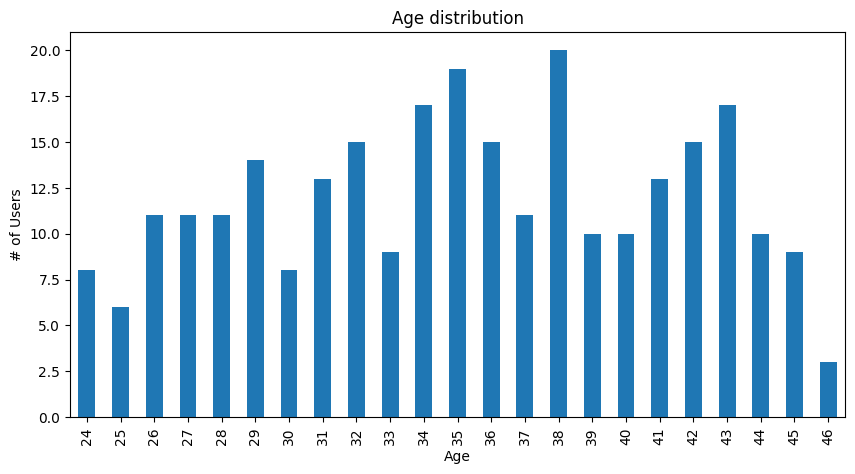

In [16]:
import dateutil
from pandas import to_datetime

if not is_dataFrame('user_df'):
    load_tables()

def age(birthdate):
    dob = to_datetime(birthdate).date() if type(birthdate) is not str \
                  else dateutil.parser.parse(birthdate).date()
    hoy = dateutil.utils.today().date()
    ddiff = hoy - dob
    edad  = int(ddiff.days / 365.25)
    # print(edad, "años")
    return edad

# Add age column to user dataframe
user_df["age"] = user_df['birthdate'].map(age)

user_df.groupby('age')['age'] \
        .count() \
        .plot.bar(
            x='age',
            figsize=(10,5),
            title="Age distribution",
            ylabel="# of Users",
            xlabel="Age"
        )

Observando la gráfica, vemos que no hay una distribución uniforme y, por tanto, podría decirse que las edades son "aleatorias" en su distribución, quizá con una prevalencia en la franja de 26 a 29 años, pero no es significativa. Eso sí, no hay gente mayor de 50 ni jóvenes de 18 a 23. Es... atípico. O:)

<Axes: ylabel='Frequency'>

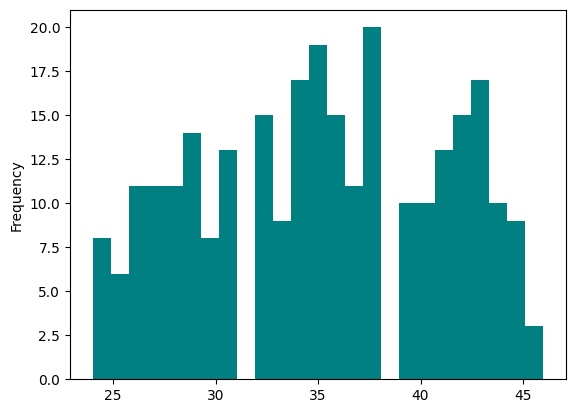

In [17]:
user_df['age'].plot.hist(bins=25, color='teal')

#### T8.01 N1E2 dues variables numèriques
¿Podría ser el valor de la transacción por... número de transacciones? ¿Tiene algún sentido?

Quizá recuperando algún ejercicio anterior; por ejemplo: los productos más vendidos y el precio...

¿O tal vez saber cúanto compran por edades? Sería sumar las ventas, o contar las ventas, pero agrupando por la edad del comprador. Es más interesante.

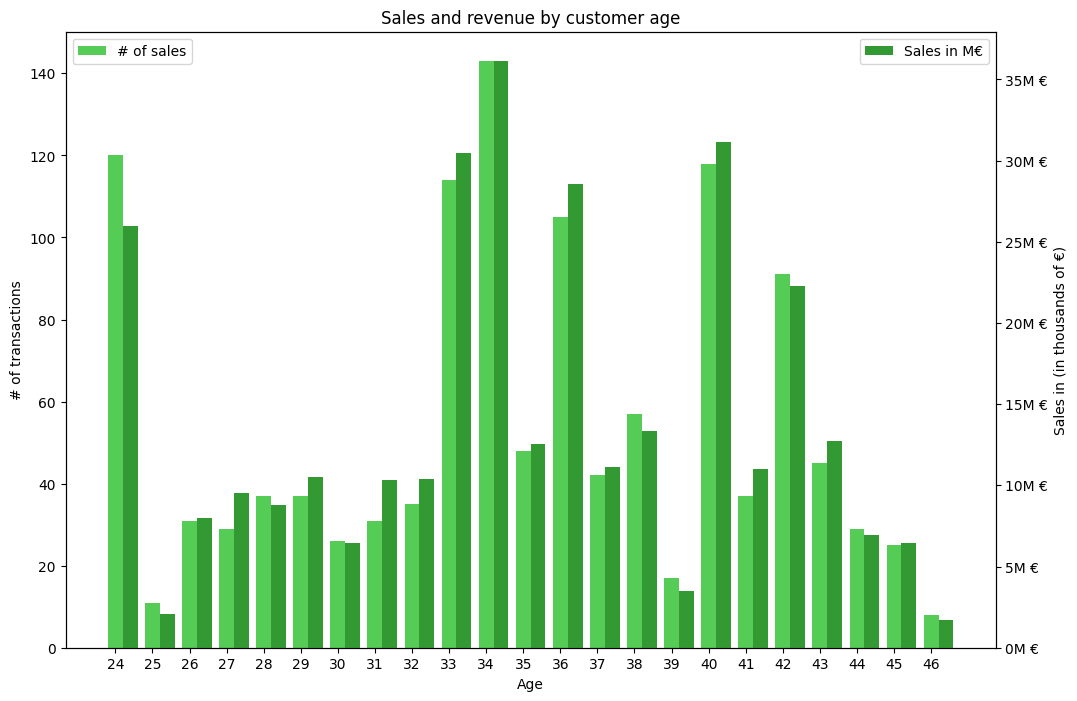

In [18]:
from math import prod
from matplotlib import pyplot, ticker
import numpy as np


load_tables()

# user_df['Client'].head()

# Create the custom dataset with user and transasction data
productos = prtr_df.merge(
                       tr_df[tr_df['declined']==0].filter([
                           'transaction_id',
                           'amount',
                           'user_id']),
                       on="transaction_id",
                       how="inner"
                    ) \
                   .merge(user_df.filter([
                       'user_id',
                       'age'
                   ]), on="user_id", how="inner")

# productos.head()

# productos.groupby(['age'])['amount'].agg('sum', 'count')

salesXage    = productos.get(['age', 'amount']) \
                        .groupby('age')['amount'] \
                        .agg(['sum', 'count'])

# salesXage['sum'] /= 1000

f, sxa_gr = pyplot.subplots(figsize=(12,8))
ages_list = salesXage.index
bar_width = 0.4
positions = np.arange(len(ages_list))

sxa_gr.bar(
    x=positions,
    height=salesXage['count'], # transactions by age
    width=bar_width,
    label='# of sales',
    color='#5c5'
)
sxa_gr.set_xlabel('Age')
sxa_gr.set_ylabel('# of transactions')
sxa_gr.set_xticks(positions, [str(n) for n in ages_list])

sxa_gr2 = sxa_gr.twinx()
sxa_gr2.bar(
    x=positions+bar_width,
    height=salesXage['sum'] / 1000,
    width=bar_width,
    label='Sales in M€',
    color='#393'
)
sxa_gr2.set_ylabel('Sales in (in thousands of €)')
sxa_gr2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%dM €'))
# pyplot.bar(countBarPos, salesXage['count'], bar_width, label='')
# pyplot.bar(sumBarPos,   salesXage['sum'], bar_width, label='')

sxa_gr.set_title("Sales and revenue by customer age")
sxa_gr.legend(loc='upper left')
sxa_gr2.legend(loc='upper right')


#### T8.01 N1E3 Una variable categòrica
Podríamos utilizar el país y categorizar las compañías en base a su país. Aunque no es del tipo "dtype.Category", se podrían considerar los países como valores categóricos: no puede haber países que no existen, por ejemplo.

<Axes: title={'center': 'Companies by Country'}, xlabel='Country', ylabel='Companies'>

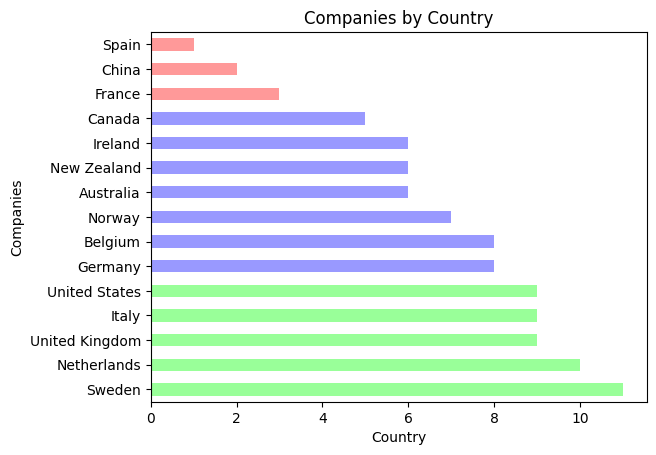

In [19]:
db_connect()

load_tables()

pastel_3colors = {4: '#f99', 8: '#99f', 'else': '#9f9'}
graph_data     = co_df.groupby('country')['country'] \
                      .count()  \
                      .sort_values(ascending=False) # comment or set to modify order

graph_data.plot.barh(
            x='age',
            title="Companies by Country",
            ylabel="Companies",
            xlabel="Country",
            color=column_colors(graph_data, pastel_3colors)
        )

Otra variable categórica es el estado de la transacción, ya que solo puede tener dos estados.

Al principio, hice este gráfico partiendo de una consulta:

C:\Users\formacio\AppData\Local\Temp\ipykernel_4380\1396384437.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=db, columns=['declined'])


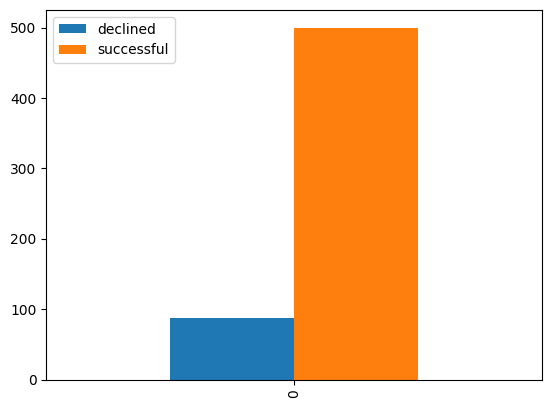

In [20]:
load_tables()

query = '''
SELECT SUM(declined)   AS declined
     , SUM(declined=0) AS successful
  FROM `transaction`
'''

if 'db' in globals() and db.is_connected:
    df = pd.read_sql(query, con=db, columns=['declined'])
    df.plot.bar()

Pero supongo que si se trata de usar pandas, la idea es hacer la selección y agregación usando la biblioteca y no SQL, ya que la "_gracia_" está en importar datos de Excel/hojas de cálculo, tablas HTML, CSV... donde no hay cómo hacer un GROUP BY o un MAX().
(Esto no se dice tampoco en el enunciado... Solo "conectar a la DB"; si conecto a una DB para hacer un select, a algunos la manipulación se nos va directamente a SQL).

<Axes: title={'center': 'Transactions'}, xlabel='Status', ylabel='# of transactions'>

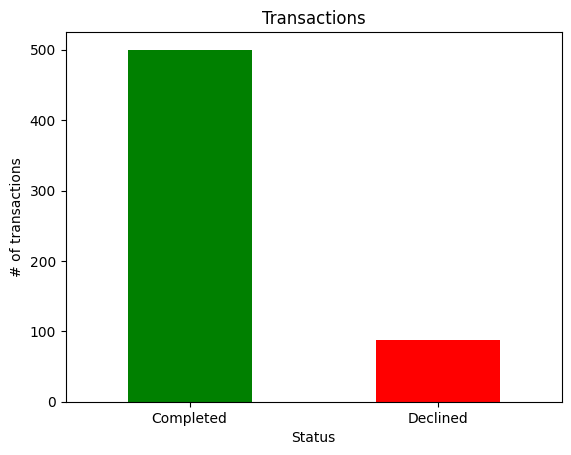

In [21]:
# Usando pandas para "calcular" las columnas, y crear el gráfico renombrando las columnas de "0" y "1" a "Completadas" y "Declinadas"ArithmeticErrordecl_df = tr_df.groupby('declined').count()
decl_df = tr_df.groupby('declined').count()

decl_df = decl_df.rename({0: "Completed", 1: "Declined"}, axis='index')['transaction_id']
# decl_df = decl_df['transaction_id']
# print(decl_df)
decl_df.plot.bar(
    title="Transactions",
    xlabel="Status",
    ylabel="# of transactions",
    color=['green', 'red'],
    rot=0
)

#### T8.01 N1E4 Una variable categòrica i una numèrica
¿Total y cantidad de compras por mes? En una gráfica doble... Hmmm... ¿El mes es una variable categórica o numérica? Si fueran fechas, diría que "más o menos numéricas", sin embargo, al agrupar por mese, estamos categorizando los datos, ¿no?

[]

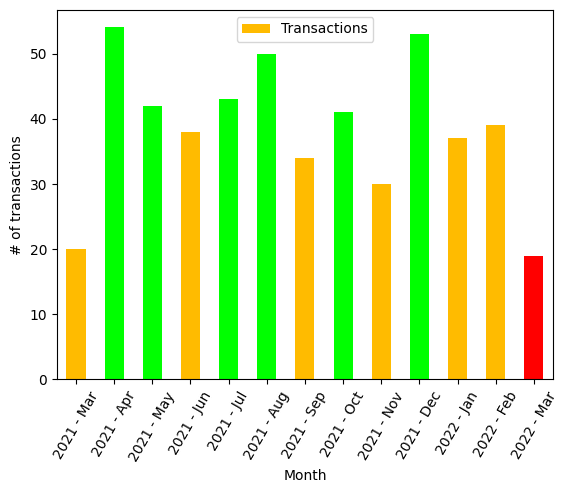

In [22]:
from matplotlib import pyplot

db_connect()
load_tables()

tr_df_agg  = tr_df[tr_df['declined']==0]  \
                        .get(['amount', 'transaction_ts'])  \
                        .groupby(pd.Grouper(
                            key='transaction_ts',
                            axis=0,
                            origin='start',
                            sort=True,
                            freq='ME'
                        )) \
                        .agg(['sum', 'count'])
tr_agg     = tr_df_agg['amount']
bar_values = tr_agg['count'].to_list()

semaphor_colors = {
    20:     '#f00',
    40:     '#fb0',
    'else': '#0f0'
}
cc = column_colors(bar_values, semaphor_colors)

xticks = [d.date().strftime('%Y - %b') for d in tr_agg.index]

graph = tr_agg['count'].plot.bar(
    # kind="bar",
    color=cc,
    rot=60,
    ylabel="# of transactions",
    xlabel="Month",
    label="Transactions"
)
graph.set_xticks(range(0, xticks.__len__()), xticks)
graph.legend(["Transactions"])
graph.plot()

#### T8.01 N1E5 Dues variables categòriques
Podríamos ver, siguiendo con resulado de transacciones y países, podemos preguntarnos por el resultado de las transacciones por país.

<Axes: title={'center': 'Transactions by Country'}, xlabel='# transactions', ylabel='Country'>

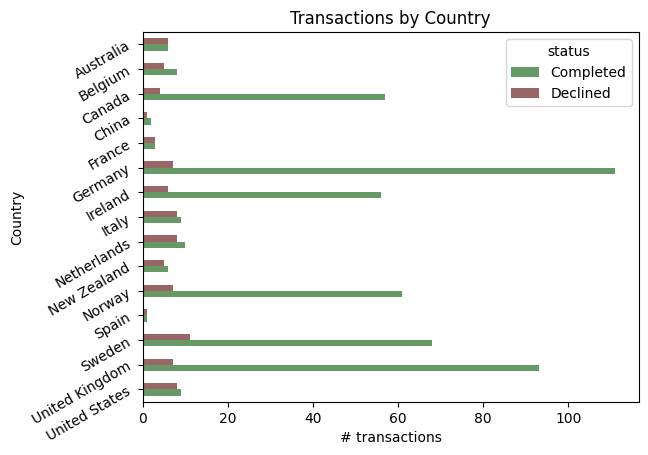

In [23]:
# Create the custom dataset with companies (country) and transasction data (declined)
cotr_df = tr_df.filter([
                    'declined',
                    'company_id'
                ]) \
                .merge(co_df.filter([
                        'company_id',
                        'country'
                    ]),
                    on="company_id",
                    how="inner"
                )
cotr_df['status'] = cotr_df['declined'].map({0: "Completed", 1: "Declined"})

graph_data = cotr_df.groupby(['country', 'status']) \
                    .size() \
                    .unstack(fill_value=0) \
                    .sort_values(by='country', ascending=False)
# print(cotr_df.head(10))
# print(graph_data.head(10))

graph_data.plot.barh(
    title='Transactions by Country',
    ylabel='Country',
    xlabel='# transactions',
    color=['#696', '#966'],
    rot=30
)

#### T8.01 N1E6 Tres variables
Aquí tenemos un agrupamiento por **país**, y mostrando la **cantidad de transacciones** _y_ el **valor** de dichas operaciones.

In [24]:
db_connect()

if db and db.is_connected:
    if 'co_df' not in globals() or type(co_df) is not pd.core.frame.DataFrame:
        load_tables()
# tr_df.head()
# co_df.head()
cotr_df = co_df.merge(tr_df, how='inner', on='company_id')

cotr_df.head()

,company_id,company_name,phone,email,country,website,transaction_id,user_id,credit_card_id,product_ids,transaction_ts,amount,latitude,longitude,declined
0,b-2222,Ac Fermentum Incorporated,06 85 56 52 33,donec.porttitor.tellus@yahoo.net,Germany,https://instagram.com/site,108B1D1D-5B23-A76C-55EF-C568E49A05DD,275,CcU-2938,[59],2021-07-07 17:43:16,293.57,83.7839,-178.8600,0
1,b-2222,Ac Fermentum Incorporated,06 85 56 52 33,donec.porttitor.tellus@yahoo.net,Germany,https://instagram.com/site,EA2C3281-C9C1-A387-44F8-729FB4B51C76,275,CcU-2938,"[59, 79, 37, 73]",2021-05-09 10:25:08,119.36,20.2004,-116.8400,1
2,b-2226,Magna A Neque Industries,04 14 44 64 62,risus.donec.nibh@icloud.org,Australia,https://whatsapp.com/group/9,7DC26247-20EC-53FE-E555-B6C2E55CA5D5,275,CcU-2945,"[71, 41]",2022-02-04 15:52:56,312.50,58.9367,-76.8171,0
3,b-2226,Magna A Neque Industries,04 14 44 64 62,risus.donec.nibh@icloud.org,Australia,https://whatsapp.com/group/9,FE96CE47-BD59-381C-4E18-E3CA3D44E8FF,275,CcU-2945,[3],2021-06-15 00:26:29,480.13,-21.8805,-112.5880,1
4,b-2230,Fusce Corp.,08 14 97 58 85,risus@protonmail.edu,United States,https://pinterest.com/sub/cars,72997E96-DC2C-A4D7-7C24-66C302F8AE5A,275,CcU-2952,"[97, 41, 3]",2022-01-30 15:16:36,239.87,43.3584,-17.6580,0


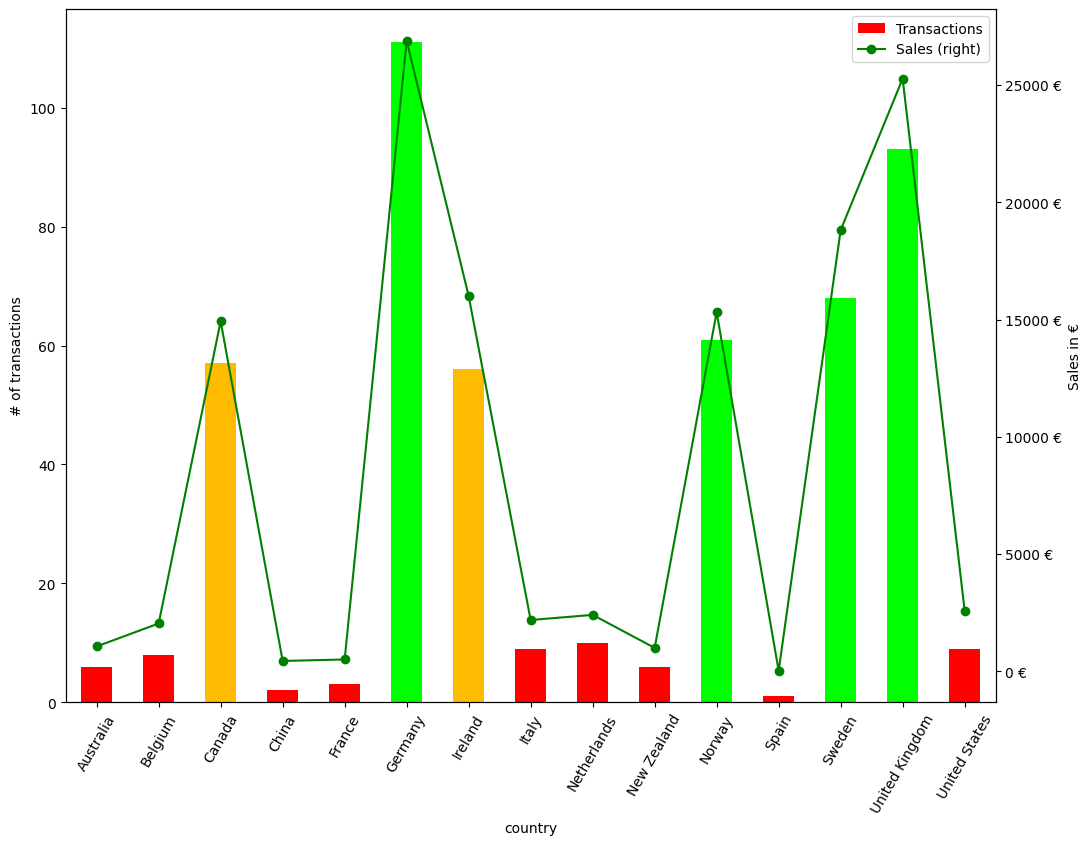

In [25]:
from matplotlib import ticker

db_connect()
load_tables()

cotr_df = co_df.merge(tr_df, how='inner', on='company_id')

tr_agg  = cotr_df[cotr_df['declined']==0]  \
                        .get(['amount', 'country'])  \
                        .groupby('country')  \
                        .agg(['sum', 'count'])

fig, ax = pyplot.subplots()
xLabels = tr_agg['amount'].index

semaphor_colors = {
    20:     '#f00',
    60:     '#fb0',
    'else': '#0f0'
}

cc = column_colors(tr_agg['amount']['count'], semaphor_colors)
# print(cc)
# print(tr_agg.head())

graph = tr_agg['amount']['count'].plot(
    kind="bar",
    figsize=(12,9),
    color=cc,
    rot=60,
    ylabel="# of transactions",
    label="Transactions",
    legend=True,
    ax=ax
)
# graph.legend(labels=("Transactions", "Sales"))

# Ventas en otra escala, para que sea visible...
graph2 = tr_agg['amount']['sum'].plot(
    kind='line',
    secondary_y=True,
    legend=True,
    ylabel='Sales in €',
    color='green',
    marker='o',
    rot=60,
    label="Sales",
    ax=graph
)
graph2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d €'))